### Tree ensemble example with TreeExplainer (XGBoost/LightGBM/CatBoost/scikit-learn/pyspark models)

In [29]:
# source: https://github.com/slundberg/shap

import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()


In [30]:
# train XGBoost model
X,y = shap.datasets.boston()

In [31]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [32]:
y[:5]

array([24. , 21.6, 34.7, 33.4, 36.2])

In [33]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [34]:
model.trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,LSTAT,9.725000,0-1,0-2,0-1,18247.609400,506.0
1,0,1,0-1,RM,6.941000,0-3,0-4,0-3,6860.234380,212.0
2,0,2,0-2,LSTAT,16.084999,0-5,0-6,0-5,2385.593750,294.0
3,0,3,0-3,DIS,1.484950,0-7,0-8,0-7,564.898438,142.0
4,0,4,0-4,RM,7.437000,0-9,0-10,0-9,713.554688,70.0
...,...,...,...,...,...,...,...,...,...,...
3437,99,40,99-40,Leaf,NaN,NaN,NaN,NaN,0.028075,2.0
3438,99,41,99-41,Leaf,NaN,NaN,NaN,NaN,0.006320,1.0
3439,99,42,99-42,Leaf,NaN,NaN,NaN,NaN,0.044162,26.0
3440,99,43,99-43,Leaf,NaN,NaN,NaN,NaN,0.040766,7.0


In [35]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)

In [36]:
shap_values = explainer.shap_values(X)
shap_values.shape

(506, 13)

In [37]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [38]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

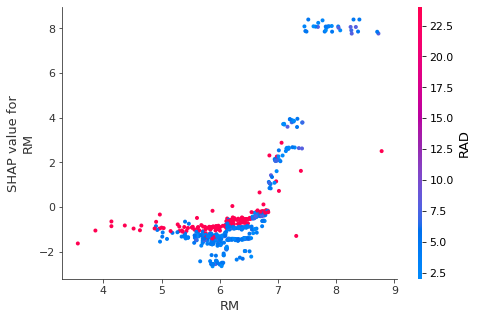

In [39]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("RM", shap_values, X)

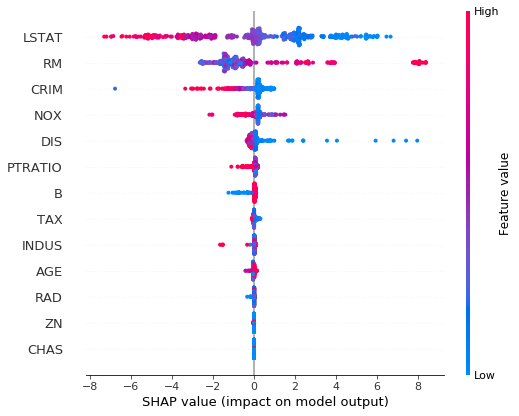

In [40]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

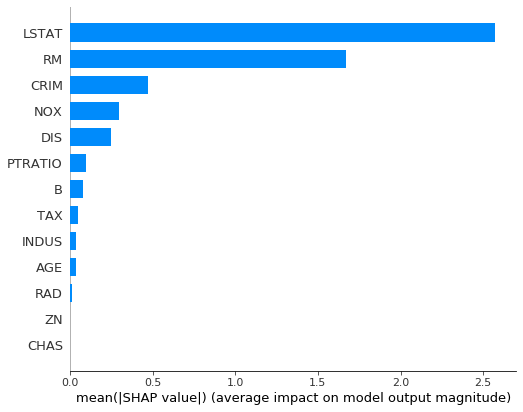

In [41]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [42]:
shap.TreeExplainer(model).shap_interaction_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


array([[[ 3.94373059e-01,  0.00000000e+00,  5.23953186e-03, ...,
          9.30645317e-03,  3.43071297e-04, -1.84640408e-01],
        [ 0.00000000e+00,  1.51976384e-03,  0.00000000e+00, ...,
          1.26827508e-05,  2.18860805e-06,  1.80482864e-04],
        [ 5.23950905e-03,  0.00000000e+00,  2.44671945e-02, ...,
          6.67424873e-04,  2.63568014e-04, -1.63009167e-02],
        ...,
        [ 9.30642337e-03,  1.26833911e-05,  6.67417422e-04, ...,
          8.81563202e-02,  4.41961922e-04, -5.07758856e-02],
        [ 3.43054533e-04,  2.18837522e-06,  2.63568014e-04, ...,
          4.41960990e-04,  5.24212271e-02, -2.26190090e-02],
        [-1.84641659e-01,  1.80392293e-04, -1.63013339e-02, ...,
         -5.07746711e-02, -2.26196963e-02,  5.33843803e+00]],

       [[ 3.79298389e-01,  0.00000000e+00,  5.23953186e-03, ...,
          9.18203779e-03,  3.51880677e-04, -2.15898693e-01],
        [ 0.00000000e+00, -4.11828980e-04,  0.00000000e+00, ...,
          1.26846135e-05,  2.18860805e

### Deep learning example with DeepExplainer (TensorFlow/Keras models)

In [32]:
from __future__ import print_function
from tensorflow import keras
from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 102s 2ms/sample - loss: 2.2749 - accuracy: 0.1538 - val_loss: 2.2328 - val_accuracy: 0.3148
Epoch 2/12
60000/60000 [==============================] - 103s 2ms/sample - loss: 2.2094 - accuracy: 0.2644 - val_loss: 2.1525 - val_accuracy: 0.5011
Epoch 3/12
60000/60000 [==============================] - 101s 2ms/sample - loss: 2.1251 - accuracy: 0.3636 - val_loss: 2.0432 - val_accuracy: 0.6249
Epoch 4/12
60000/60000 [==============================] - 94s 2ms/sample - loss: 2.0112 - accuracy: 0.4464 - val_loss: 1.8990 - val_accuracy: 0.6848
Epoch 5/12
60000/60000 [==============================] - 100s 2ms/sample - loss: 1.8708 - accuracy: 0.5066 - val_loss: 1.7245 - val_accuracy: 0.7124
Epoch 6/12
60000/60000 [==============================] - 92s 2ms/sample - loss: 1.7104 - accuracy: 0.5509 - val_loss: 1.5307 - 

In [33]:
import shap
import numpy as np

In [34]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]


In [35]:
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)


keras is no longer supported, please use tf.keras instead.


In [36]:
shap_values = e.shap_values(x_test[1:5])


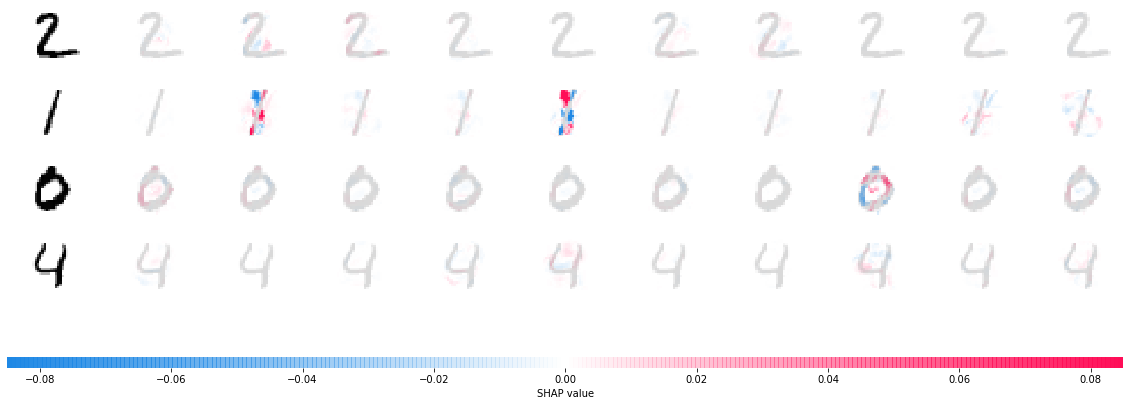

In [37]:

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])

### Deep learning example with GradientExplainer (TensorFlow/Keras/PyTorch models)

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow.keras.backend as K
import numpy as np
import json
import shap


In [4]:

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

TypeError: Tensor is unhashable if Tensor equality is enabled. Instead, use tensor.experimental_ref() as the key.

### Model agnostic example with KernelExplainer (explains any function)

In [6]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)


The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [8]:
X_train.describe(include='all')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,120.000000,120.000000,120.000000,120.000000
mean,5.880833,3.053333,3.815833,1.231667
std,0.850437,0.431907,1.784904,0.775354
min,4.300000,2.000000,1.100000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.500000,3.300000,5.200000,1.900000
max,7.900000,4.400000,6.900000,2.500000


In [27]:
Y_train

array([2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 0, 0, 2, 1, 0, 0,
       1, 0, 2, 1, 0, 1, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2,
       0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1,
       0, 2, 0, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 1,
       1, 1, 1, 0, 0, 0, 2, 1, 2, 0])

In [9]:

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [25]:
svm.predict_proba([X_test.iloc[0,:]])

array([[0.01164541, 0.00991881, 0.97843577]])

In [26]:
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


SHAPError: Model type not yet supported by TreeExplainer: <class 'tensorflow.python.keras.engine.training.Model'>